# Spotify Recommendation Algorithm

### Spotify Authentication

In [1]:
# Import libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
from spotipy.oauth2 import SpotifyOAuth

os.environ["SPOTIPY_CLIENT_ID"] = "81fee852cceb4259910e7d2ff78493c3"
os.environ["SPOTIPY_CLIENT_SECRET"] = "ad4360215d7641ee809275cc5cdd4a6c"
os.environ["SPOTIPY_REDIRECT_URI"] = "http://localhost:8080/callback"

C:\Users\febel\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [73]:
# Set account info
cid = '81fee852cceb4259910e7d2ff78493c3'
secret = 'XXXXX'
username = 'francescab13'

# Connect and create Spotify instance
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=10)

## Data Gathering

#### Retrieve track ID's from 'Like' and 'Dislike' playlists

In [3]:
# Get data from 'Likes' playlist
good_ids = []
pl_id = 'spotify:playlist:2O6XH1ip37KOllmc1KoYEs'
offset = 0

while True:
    response = sp.playlist_tracks(pl_id,
                                  offset=offset,
                                  fields='items.track.id,total')
    good_ids.append(response['items'])
    offset = offset + len(response['items'])

    if len(response['items']) == 0:
        break

# Flatten list of lists of JSON
good_flatten = []
for sublist in good_ids:
    for item in sublist:
        good_flatten.append(item)

# Check good track ID list
good_flatten[0:5]

[{'track': {'id': '75Q69chmd8CEZbVsA4CDMm'}},
 {'track': {'id': '38kjIfRtXsUxXyzhsKwX7i'}},
 {'track': {'id': '1YT8xkroYGNLGR4qhuWLC4'}},
 {'track': {'id': '76gYk9g0bZj47NyIKzjLF6'}},
 {'track': {'id': '7tvuLLroI0n6uYBWuFig5d'}}]

In [4]:
# Get data from 'Dislikes' playlist
bad_ids = []
pl_id = 'spotify:playlist:58KlzYsGNQoujtrQc2CU5d'
offset = 0

while True:
    response = sp.playlist_tracks(pl_id,
                                  offset=offset,
                                  fields='items.track.id,total')
    bad_ids.append(response['items'])
    offset = offset + len(response['items'])

    if len(response['items']) == 0:
        break

# Flatten list of lists of JSON
bad_flatten = []
for sublist in bad_ids:
    for item in sublist:
        bad_flatten.append(item)
        
# Check bad track ID list
bad_flatten[0:5]

[{'track': {'id': '1YwNlWLf8auhazSQUDQLFU'}},
 {'track': {'id': '1xShPgQbOUa98avWJQFDBY'}},
 {'track': {'id': '3GREm6zSHwKZsJxl0hqbAQ'}},
 {'track': {'id': '0C6EIiQu8CS4eYtOCMEiAd'}},
 {'track': {'id': '0puf9yIluy9W0vpMEUoAnN'}}]

#### Get track characteristic data

In [5]:
# Compile list of 'good' track IDs
good_id_list = []
for i in range(0, len(good_flatten)):
    good_id_list.append(good_flatten[i]['track']['id'])
good_id_list = [x for x in good_id_list if x]

# Retrieve track characteristics
good_features = []
for i in range(0, len(good_id_list)):
    if not good_id_list[i]:
        continue
    else:
        good_features.append(sp.audio_features(good_id_list[i]))

# Flatten JSON list
good_features_flat = []
for sublist in good_features:
    for item in sublist:
        good_features_flat.append(item)
        
# Check 'good' features list
good_features_flat[0:3]

[{'acousticness': 0.352,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/75Q69chmd8CEZbVsA4CDMm',
  'danceability': 0.833,
  'duration_ms': 148494,
  'energy': 0.545,
  'id': '75Q69chmd8CEZbVsA4CDMm',
  'instrumentalness': 0,
  'key': 2,
  'liveness': 0.0915,
  'loudness': -4.004,
  'mode': 0,
  'speechiness': 0.462,
  'tempo': 77.035,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/75Q69chmd8CEZbVsA4CDMm',
  'type': 'audio_features',
  'uri': 'spotify:track:75Q69chmd8CEZbVsA4CDMm',
  'valence': 0.541},
 {'acousticness': 0.794,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/38kjIfRtXsUxXyzhsKwX7i',
  'danceability': 0.596,
  'duration_ms': 383025,
  'energy': 0.248,
  'id': '38kjIfRtXsUxXyzhsKwX7i',
  'instrumentalness': 0,
  'key': 0,
  'liveness': 0.0872,
  'loudness': -14.576,
  'mode': 0,
  'speechiness': 0.274,
  'tempo': 112.043,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/38kjIfRtXsUxXyzhsKwX7i',


In [6]:
# Compile list of 'bad' track IDs
bad_id_list = []
for i in range(0, len(bad_flatten)):
    bad_id_list.append(bad_flatten[i]['track']['id'])
bad_id_list = [x for x in bad_id_list if x]

# Retrieve track characteristics
bad_features = []
for i in range(0, len(bad_id_list)):
    if not bad_id_list[i]:
        continue
    else:
        bad_features.append(sp.audio_features(bad_id_list[i]))

# Flatten JSON list
bad_features_flat = []
for sublist in bad_features:
    for item in sublist:
        bad_features_flat.append(item)
        
# Check 'bad' features list
bad_features_flat[0:3]

[{'acousticness': 0.155,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1YwNlWLf8auhazSQUDQLFU',
  'danceability': 0.641,
  'duration_ms': 257333,
  'energy': 0.812,
  'id': '1YwNlWLf8auhazSQUDQLFU',
  'instrumentalness': 4.43e-05,
  'key': 0,
  'liveness': 0.078,
  'loudness': -7.945,
  'mode': 0,
  'speechiness': 0.0293,
  'tempo': 112.777,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/1YwNlWLf8auhazSQUDQLFU',
  'type': 'audio_features',
  'uri': 'spotify:track:1YwNlWLf8auhazSQUDQLFU',
  'valence': 0.822},
 {'acousticness': 0.0112,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1xShPgQbOUa98avWJQFDBY',
  'danceability': 0.637,
  'duration_ms': 224907,
  'energy': 0.682,
  'id': '1xShPgQbOUa98avWJQFDBY',
  'instrumentalness': 0.0234,
  'key': 11,
  'liveness': 0.0473,
  'loudness': -11.625,
  'mode': 1,
  'speechiness': 0.0366,
  'tempo': 129.983,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/1xShPgQbO

#### Create dataframes for 'liked' and 'disliked' tracks with audio features

In [7]:
# Create 'Like' dataframe
like_df = pd.DataFrame.from_records(good_features_flat)

# Retrieve song and artist names to add to dataframe
good_song_names = []
good_artists = []
for index, row in like_df.iterrows():
    try:
        response = sp.track(str(row['uri']))
        good_song_names.append(response['name'])
        good_artists.append(response['artists'][0]['name'])
    except SpotifyException as e:
        good_song_names.append('Unknown')
        good_artists.append('Unknown')

# Create 'song_name' and 'artist' columns
like_df['song_name'] = good_song_names
like_df['artist'] = good_artists

# Check dataframe
like_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist
0,0.833,0.545,2,-4.004,0,0.4620,0.352000,0.000,0.0915,0.541,77.035,audio_features,75Q69chmd8CEZbVsA4CDMm,spotify:track:75Q69chmd8CEZbVsA4CDMm,https://api.spotify.com/v1/tracks/75Q69chmd8CE...,https://api.spotify.com/v1/audio-analysis/75Q6...,148494,4,Gorgeous,mansionz
1,0.596,0.248,0,-14.576,0,0.2740,0.794000,0.000,0.0872,0.189,112.043,audio_features,38kjIfRtXsUxXyzhsKwX7i,spotify:track:38kjIfRtXsUxXyzhsKwX7i,https://api.spotify.com/v1/tracks/38kjIfRtXsUx...,https://api.spotify.com/v1/audio-analysis/38kj...,383025,4,i'm thinking about horses,mansionz
2,0.546,0.771,3,-7.560,0,0.1160,0.011700,0.351,0.3350,0.701,130.224,audio_features,1YT8xkroYGNLGR4qhuWLC4,spotify:track:1YT8xkroYGNLGR4qhuWLC4,https://api.spotify.com/v1/tracks/1YT8xkroYGNL...,https://api.spotify.com/v1/audio-analysis/1YT8...,265947,4,Number 9,Moon Hooch
3,0.515,0.827,7,-5.423,1,0.0923,0.000361,0.838,0.1380,0.427,173.988,audio_features,76gYk9g0bZj47NyIKzjLF6,spotify:track:76gYk9g0bZj47NyIKzjLF6,https://api.spotify.com/v1/tracks/76gYk9g0bZj4...,https://api.spotify.com/v1/audio-analysis/76gY...,246094,4,Execute,Excision
4,0.387,0.678,0,-8.399,1,0.0817,0.001080,0.872,0.1010,0.368,172.641,audio_features,7tvuLLroI0n6uYBWuFig5d,spotify:track:7tvuLLroI0n6uYBWuFig5d,https://api.spotify.com/v1/tracks/7tvuLLroI0n6...,https://api.spotify.com/v1/audio-analysis/7tvu...,562707,3,Lateralus,TOOL


In [8]:
# Create 'Dislike' dataframe
dislike_df = pd.DataFrame.from_records(bad_features_flat)

# Retrieve song and artist names to add to dataframe
bad_song_names = []
bad_artists = []
for index, row in dislike_df.iterrows():
    try:
        response = sp.track(str(row['uri']))
        bad_song_names.append(response['name'])
        bad_artists.append(response['artists'][0]['name'])
    except SpotifyException as e:
        bad_song_names.append('Unknown')
        bad_artists.append('Unknown')

# Create 'song_name' and 'artist' columns
dislike_df['song_name'] = bad_song_names
dislike_df['artist'] = bad_artists

# Check dataframe
dislike_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist
0,0.641,0.812,0,-7.945,0,0.0293,0.1550,0.000044,0.0780,0.822,112.777,audio_features,1YwNlWLf8auhazSQUDQLFU,spotify:track:1YwNlWLf8auhazSQUDQLFU,https://api.spotify.com/v1/tracks/1YwNlWLf8auh...,https://api.spotify.com/v1/audio-analysis/1YwN...,257333,4,Enjoy the Silence - Single Mix,Depeche Mode
1,0.637,0.682,11,-11.625,1,0.0366,0.0112,0.023400,0.0473,0.714,129.983,audio_features,1xShPgQbOUa98avWJQFDBY,spotify:track:1xShPgQbOUa98avWJQFDBY,https://api.spotify.com/v1/tracks/1xShPgQbOUa9...,https://api.spotify.com/v1/audio-analysis/1xSh...,224907,4,Personal Jesus - Original Single Version,Depeche Mode
2,0.679,0.829,9,-7.288,0,0.0604,0.0875,0.000002,0.3180,0.812,119.960,audio_features,3GREm6zSHwKZsJxl0hqbAQ,spotify:track:3GREm6zSHwKZsJxl0hqbAQ,https://api.spotify.com/v1/tracks/3GREm6zSHwKZ...,https://api.spotify.com/v1/audio-analysis/3GRE...,232080,4,People Are People - 2006 Remaster,Depeche Mode
3,0.678,0.658,8,-7.300,1,0.0280,0.0093,0.239000,0.1180,0.359,114.209,audio_features,0C6EIiQu8CS4eYtOCMEiAd,spotify:track:0C6EIiQu8CS4eYtOCMEiAd,https://api.spotify.com/v1/tracks/0C6EIiQu8CS4...,https://api.spotify.com/v1/audio-analysis/0C6E...,294040,4,Policy of Truth - 2006 Remaster,Depeche Mode
4,0.706,0.786,0,-3.417,0,0.0910,0.2600,0.000000,0.3800,0.751,150.028,audio_features,0puf9yIluy9W0vpMEUoAnN,spotify:track:0puf9yIluy9W0vpMEUoAnN,https://api.spotify.com/v1/tracks/0puf9yIluy9W...,https://api.spotify.com/v1/audio-analysis/0puf...,199387,4,Bang Bang,Jessie J


## Exploratory Data Analysis

In [9]:
#Importing the function
from pandas_profiling import ProfileReport

In [33]:
like_profile = ProfileReport(like_df, title='Liked Songs Pandas Profiling Report', explorative = True)
like_profile
like_profile.to_file('like_playlist_pandas_profile.html')

In [34]:
dislike_profile = ProfileReport(dislike_df, title='Disliked Songs Pandas Profiling Report', explorative = True)
dislike_profile
dislike_profile.to_file('dislike_playlist_pandas_profile.html')

## Data Visualization

In [12]:
# Create list of audio feature column names
trait_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
             'liveness', 'valence']
discrete_trait_cols = ['key', 'mode', 'tempo', 'time_signature']

#### Dist Plots

##### Tempo

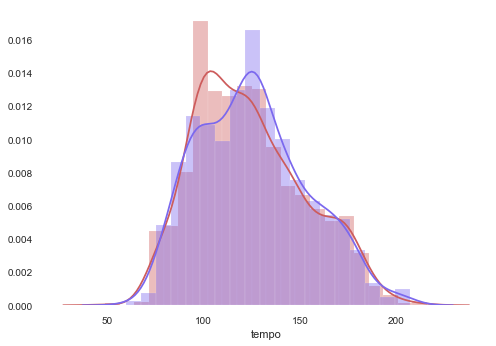

In [13]:
sns.distplot(like_df['tempo'], color='indianred', axlabel='Tempo')
sns.distplot(dislike_df['tempo'], color='mediumslateblue')
plt.show()

##### Danceability

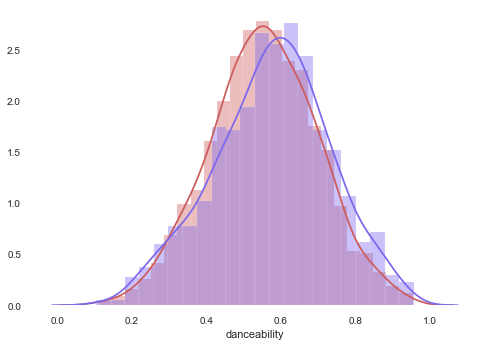

In [14]:
sns.distplot(like_df['danceability'], color='indianred', axlabel='Danceability')
sns.distplot(dislike_df['danceability'], color='mediumslateblue')
plt.show()

##### Energy

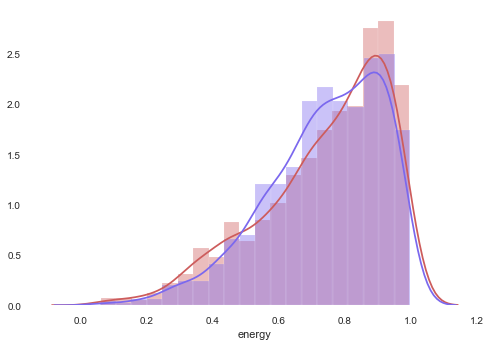

In [15]:
sns.distplot(like_df['energy'], color='indianred', axlabel='Energy')
sns.distplot(dislike_df['energy'], color='mediumslateblue')
plt.show()

##### Loudness

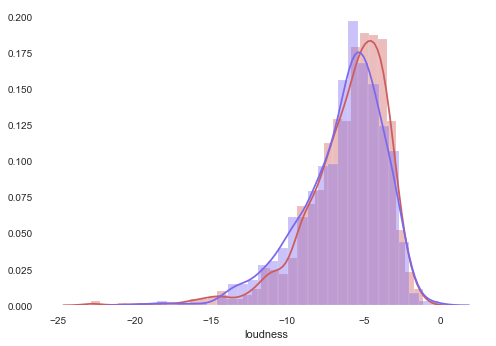

In [16]:
sns.distplot(like_df['loudness'], color='indianred', axlabel='Loudness')
sns.distplot(dislike_df['loudness'], color='mediumslateblue')
plt.show()

##### Speechiness

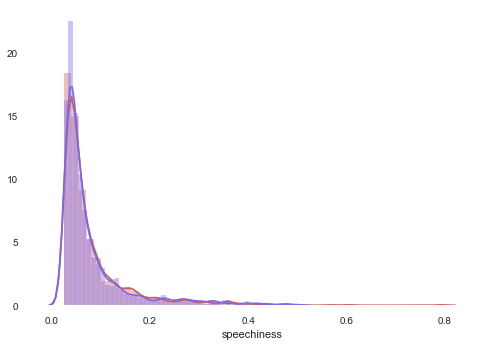

In [17]:
sns.distplot(like_df['speechiness'], color='indianred', axlabel='Speechiness')
sns.distplot(dislike_df['speechiness'], color='mediumslateblue')
plt.show()

##### Acousticness

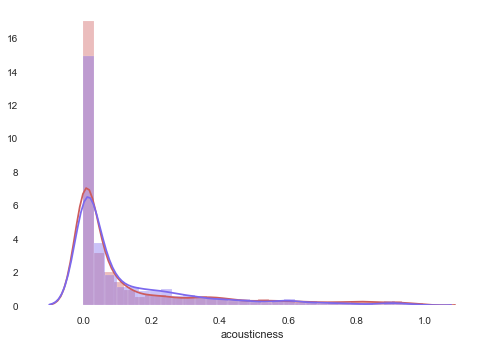

In [18]:
sns.distplot(like_df['acousticness'], color='indianred', axlabel='Acousticness')
sns.distplot(dislike_df['acousticness'], color='mediumslateblue')
plt.show()

##### Instrumentalness

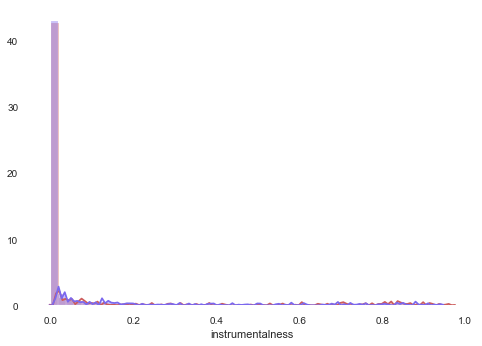

In [19]:
sns.distplot(like_df['instrumentalness'], color='indianred', axlabel='Instrumentalness')
sns.distplot(dislike_df['instrumentalness'], color='mediumslateblue')
plt.show()

##### Liveness

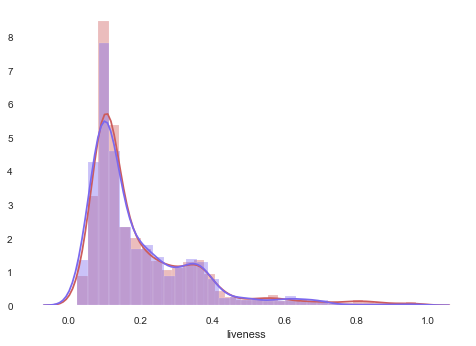

In [20]:
sns.distplot(like_df['liveness'], color='indianred', axlabel='Liveness')
sns.distplot(dislike_df['liveness'], color='mediumslateblue')
plt.show()

##### Valence

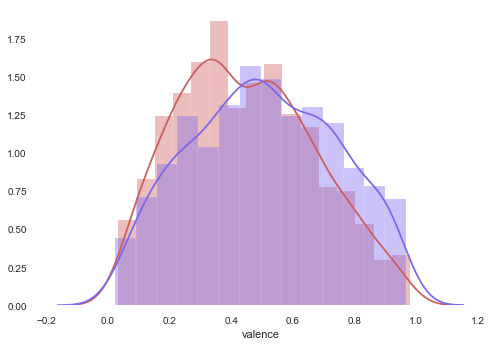

In [21]:
sns.distplot(like_df['valence'], color='indianred', axlabel='Valence')
sns.distplot(dislike_df['valence'], color='mediumslateblue')
plt.show()

##### Key

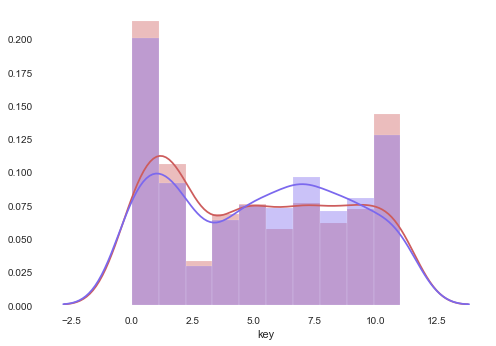

In [22]:
sns.distplot(like_df['key'], color='indianred', axlabel='Key')
sns.distplot(dislike_df['key'], color='mediumslateblue')
plt.show()

#### Frequency Plots

##### Time Signature & Mode

C:\Users\febel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


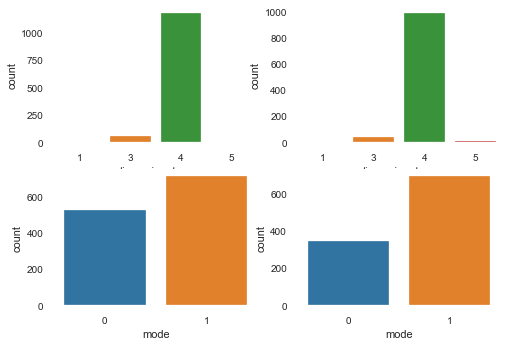

In [23]:
fig, ax = plt.subplots(2, 2)
sns.countplot(like_df['time_signature'], ax=ax[0,0])
sns.countplot(dislike_df['time_signature'], ax=ax[0,1])
sns.countplot(like_df['mode'], ax=ax[1,0])
sns.countplot(dislike_df['mode'], ax=ax[1,1])
fig.show()

#### Pair Plots

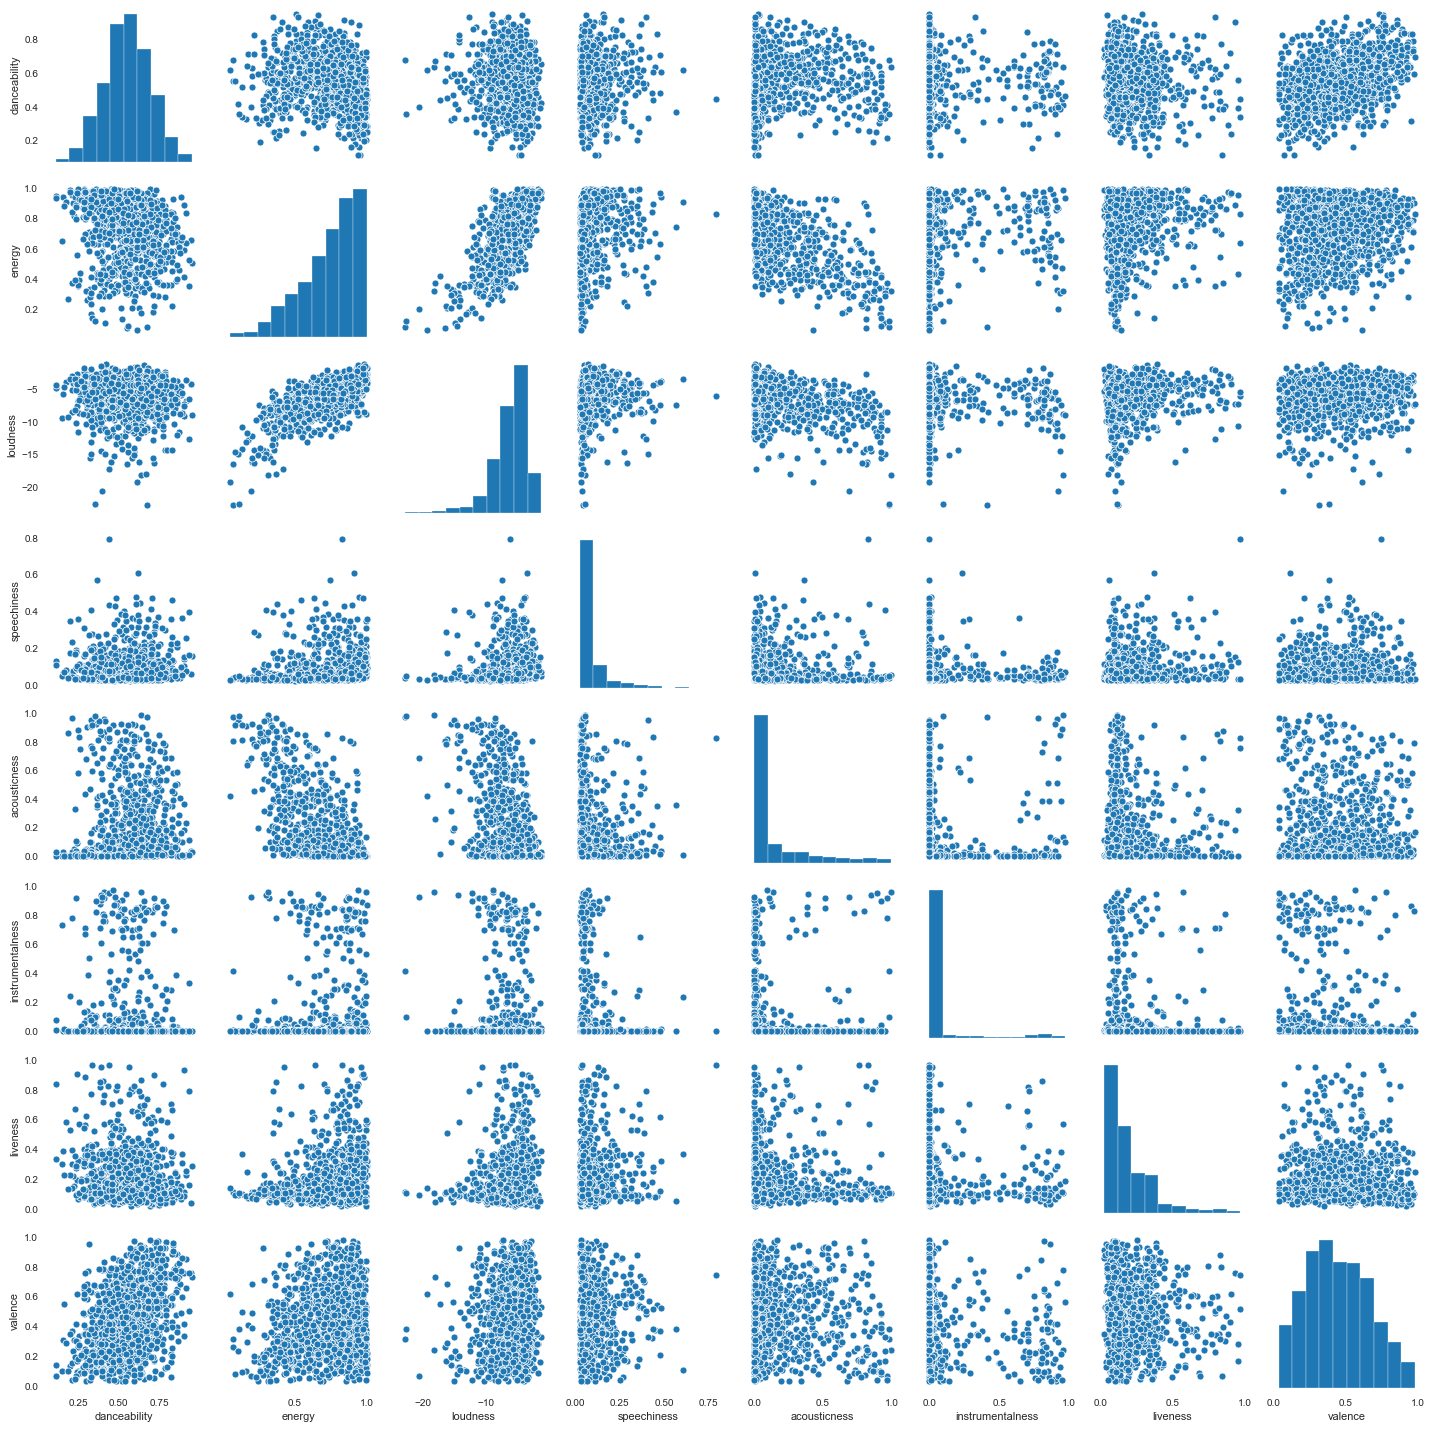

In [24]:
like_pairplot = sns.pairplot(like_df[trait_cols])

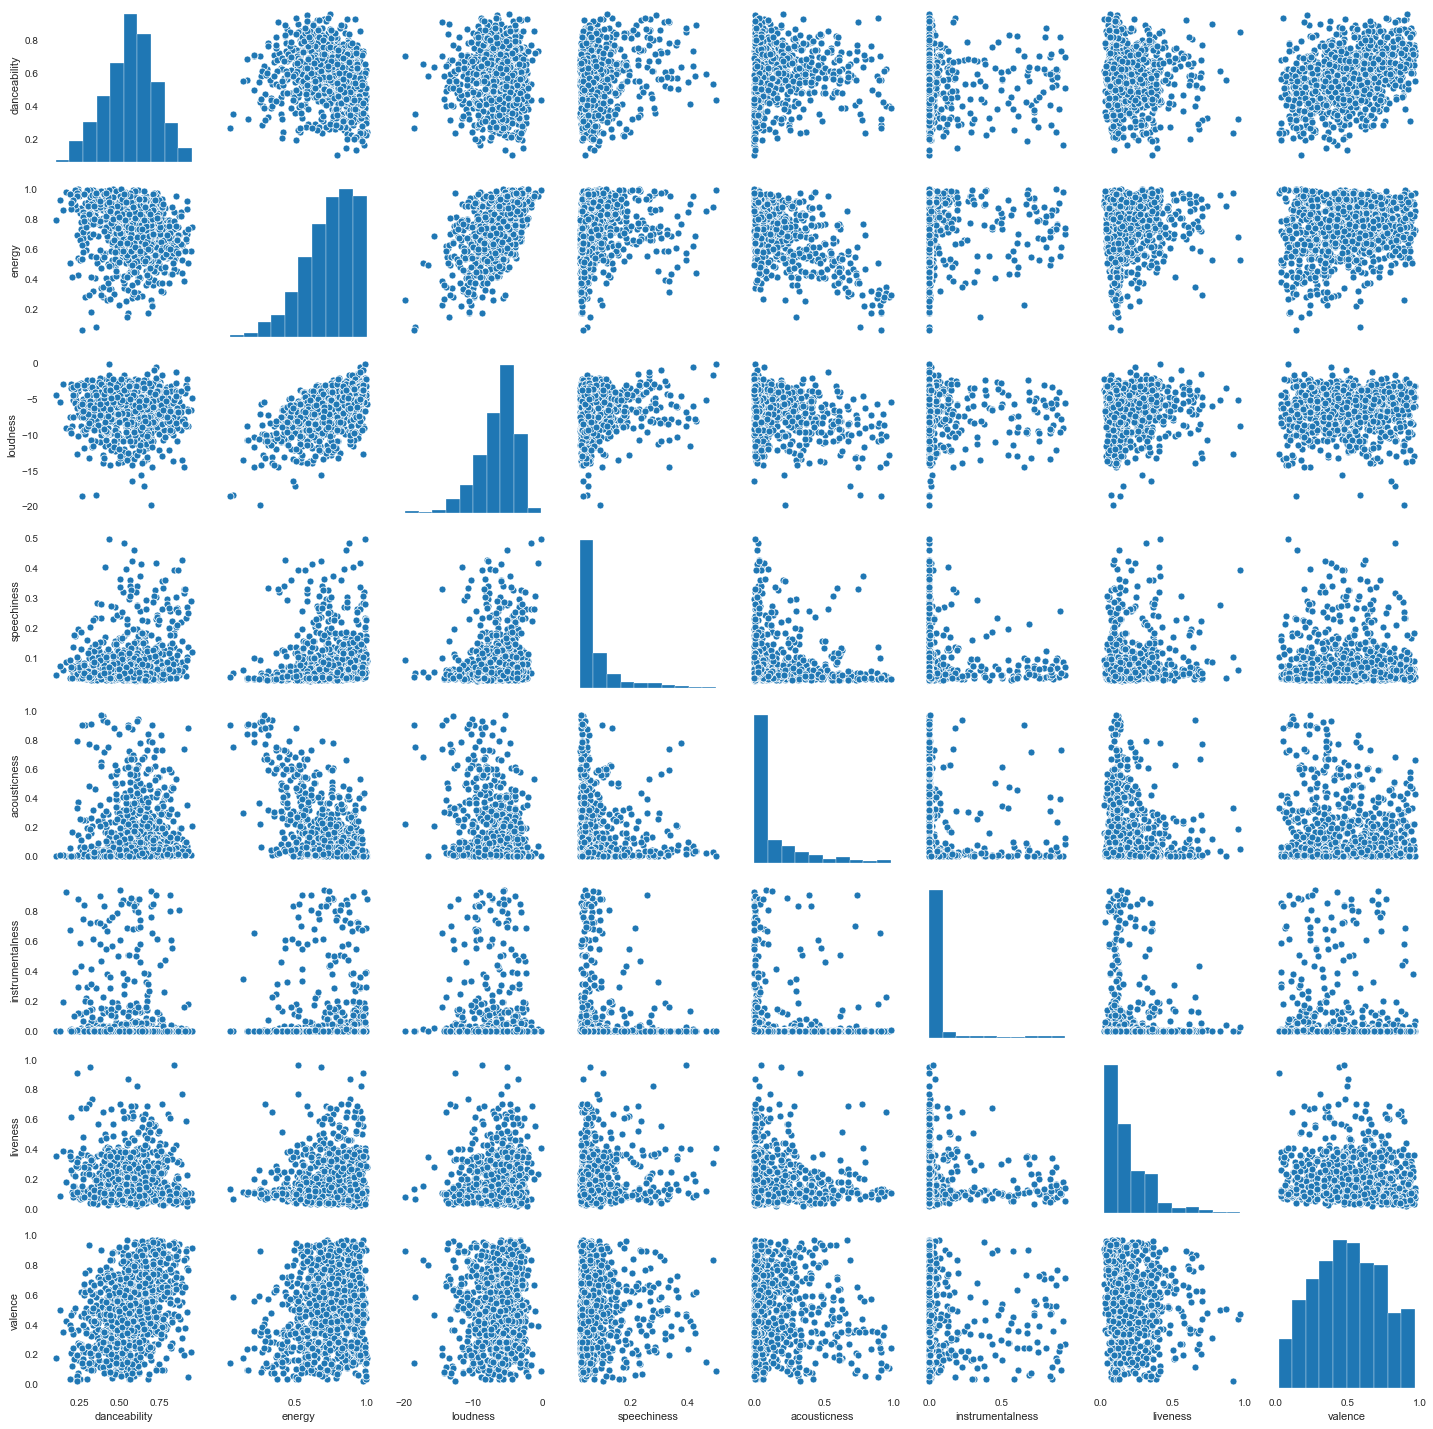

In [25]:
dislike_pairplot = sns.pairplot(dislike_df[trait_cols])

#### Correlation Heatmaps

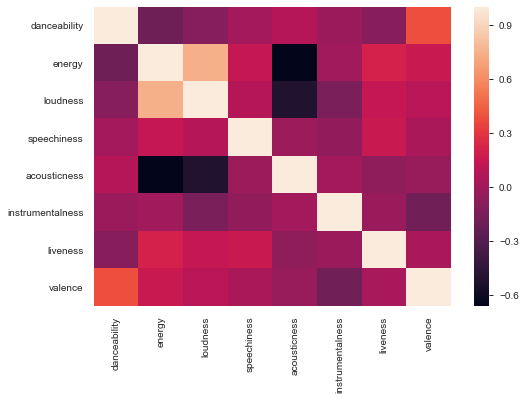

In [26]:
# Calculate correlations
corr = like_df[trait_cols].corr()
 
# Heatmap
like_corr_heatmap = sns.heatmap(corr)
figure = like_corr_heatmap.get_figure()    

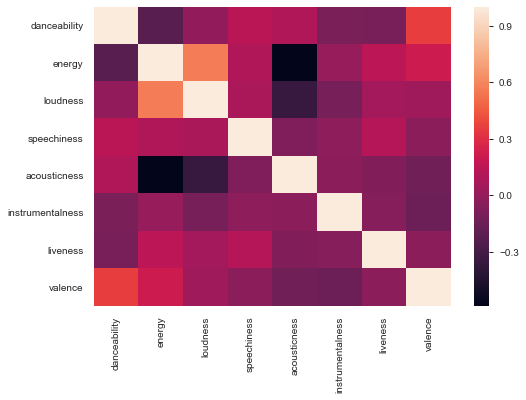

In [27]:
# Calculate correlations
corr = dislike_df[trait_cols].corr()
 
# Heatmap
dislike_corr_heatmap = sns.heatmap(corr)
figure = dislike_corr_heatmap.get_figure()    

## Model Creation/Training

#### Preparation

In [28]:
# Assign tags to liked and disliked songs
like_df['target'] = 1
dislike_df['target'] = 0

In [29]:
# Create combined dataframe
dfs = [like_df, dislike_df]
full_df = pd.concat(dfs)

In [37]:
# Creating training/test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
train, test = train_test_split(full_df, test_size = 0.15)

In [38]:
#Define feature sets
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
              'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
x_train = train[features]
y_train = train["target"]
x_test = test[features]
y_test = test["target"]

#### Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='gini', 
                             min_samples_split=100, 
                             max_depth=11)

dt = dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  56.6 %


#### K-Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
score = accuracy_score(y_test, knn_pred) * 100
print("Accuracy using KNN Tree: ", round(score, 1), "%")

Accuracy using KNN Tree:  49.0 %


#### AdaBoost/Gradient Boost

In [41]:
# Import packages
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)
score = accuracy_score(y_test, ada_pred) * 100
print("Accuracy using ada: ", round(score, 1), "%")

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
predicted = gbc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Gbc: ", round(score, 1), "%")

Accuracy using ada:  63.3 %
Accuracy using Gbc:  63.3 %


#### Naive Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()  # instantiate model
y_pred = gnb.fit(x_train, y_train).predict(x_test)  # train model and get predictions

# get classification metrics
gnb_pred = ada.predict(x_test)
score = accuracy_score(y_test, gnb_pred) * 100
print("Accuracy using GNB: ", round(score, 1), "%")

Accuracy using GNB:  63.3 %


## Model Tuning

In [43]:
from sklearn.model_selection import GridSearchCV, KFold

In [44]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
ada = AdaBoostClassifier()
search_grid = {'n_estimators':[100,250,500,750,1000,1500,2000],'learning_rate':[.001,0.01,.1]}
search = GridSearchCV(estimator=ada, param_grid=search_grid, scoring='accuracy', 
                      n_jobs=1, cv=crossvalidation)

In [45]:
search.fit(x_test, y_test)
search.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [46]:
ada2 = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
ada2.fit(x_train, y_train)
ada2_pred = ada2.predict(x_test)
score = accuracy_score(y_test, ada2_pred) * 100
print("Accuracy using AdaBoost: ", round(score, 1), "%")

Accuracy using AdaBoost:  64.4 %


## Model Re-Testing

#### Import Test Playlist

In [47]:
# Bring in test playlist
test_ids = []
pl_id = 'spotify:playlist:3NpYLX125c2wLIvTwtfHZm'
offset = 0

while True:
    response = sp.playlist_tracks(pl_id,
                                  offset=offset,
                                  fields='items.track.id,total')
    test_ids.append(response['items'])
    offset = offset + len(response['items'])

    if len(response['items']) == 0:
        break

# Flatten list of lists of JSON
test_flatten = []
for sublist in test_ids:
    for item in sublist:
        test_flatten.append(item)

In [48]:
# Compile list of test track IDs
test_id_list = []
for i in range(0, len(test_flatten)):
    test_id_list.append(test_flatten[i]['track']['id'])
test_id_list = [x for x in test_id_list if x]

# Retrieve track characteristics
test_features = []
for i in range(0, len(test_id_list)):
    if not test_id_list[i]:
        continue
    else:
        test_features.append(sp.audio_features(test_id_list[i]))

# Flatten JSON list
test_features_flat = []
for sublist in test_features:
    for item in sublist:
        test_features_flat.append(item)

In [49]:
# Create test dataframe
test_df = pd.DataFrame.from_records(test_features_flat)

# Retrieve song and artist names to add to dataframe
test_song_names = []
test_artists = []
for index, row in test_df.iterrows():
    try:
        response = sp.track(str(row['uri']))
        test_song_names.append(response['name'])
        test_artists.append(response['artists'][0]['name'])
    except SpotifyException as e:
        test_song_names.append('Unknown')
        test_artists.append('Unknown')

# Create 'song_name' and 'artist' columns
test_df['song_name'] = test_song_names
test_df['artist'] = test_artists

# Check dataframe
test_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist
0,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,audio_features,6CDzDgIUqeDY5g8ujExx2f,spotify:track:6CDzDgIUqeDY5g8ujExx2f,https://api.spotify.com/v1/tracks/6CDzDgIUqeDY...,https://api.spotify.com/v1/audio-analysis/6CDz...,238805,4,Heat Waves,Glass Animals
1,0.627,0.643,10,-8.833,0,0.0454,0.0363,0.000056,0.0917,0.273,105.012,audio_features,67lAc58pjrw9EnXO5qCRjL,spotify:track:67lAc58pjrw9EnXO5qCRjL,https://api.spotify.com/v1/tracks/67lAc58pjrw9...,https://api.spotify.com/v1/audio-analysis/67lA...,392000,4,I Will Stay,Flux Pavilion
2,0.537,0.856,2,-4.350,1,0.0685,0.0751,0.000813,0.3350,0.401,129.836,audio_features,6aLl8i6NEA3nzPWVtjFhGp,spotify:track:6aLl8i6NEA3nzPWVtjFhGp,https://api.spotify.com/v1/tracks/6aLl8i6NEA3n...,https://api.spotify.com/v1/audio-analysis/6aLl...,216000,4,Bass Jam,BONNIE X CLYDE
3,0.572,0.902,1,-4.294,1,0.0418,0.1230,0.000024,0.1660,0.543,164.988,audio_features,4rvfuttxt34i3rPbHYkSw1,spotify:track:4rvfuttxt34i3rPbHYkSw1,https://api.spotify.com/v1/tracks/4rvfuttxt34i...,https://api.spotify.com/v1/audio-analysis/4rvf...,170364,4,Voices,Prblm Chld
4,0.710,0.909,2,-2.777,1,0.0639,0.0135,0.001230,0.3030,0.648,115.001,audio_features,6EJiVf7U0p1BBfs0qqeb1f,spotify:track:6EJiVf7U0p1BBfs0qqeb1f,https://api.spotify.com/v1/tracks/6EJiVf7U0p1B...,https://api.spotify.com/v1/audio-analysis/6EJi...,207960,4,Cut To The Feeling,Carly Rae Jepsen


In [50]:
# Assign boolean like/dislike values
t = ([1] * 25) + ([0] * 25)

test_df['target'] = t

#### Test Data Visualizations

##### Tempo

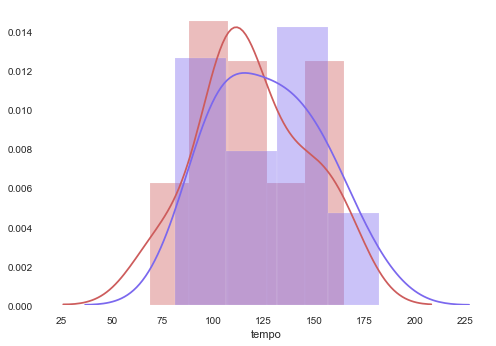

In [51]:
sns.distplot(test_df['tempo'][test_df['target'] == 1], color='indianred', axlabel='Tempo')
sns.distplot(test_df['tempo'][test_df['target'] == 0], color='mediumslateblue')
plt.show()

##### Danceability

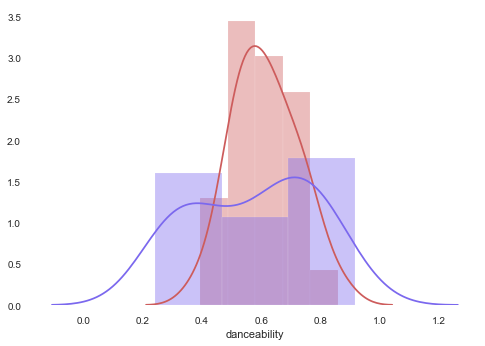

In [52]:
sns.distplot(test_df['danceability'][test_df['target'] == 1], color='indianred', axlabel='Danceability')
sns.distplot(test_df['danceability'][test_df['target'] == 0], color='mediumslateblue')
plt.show()

##### Energy

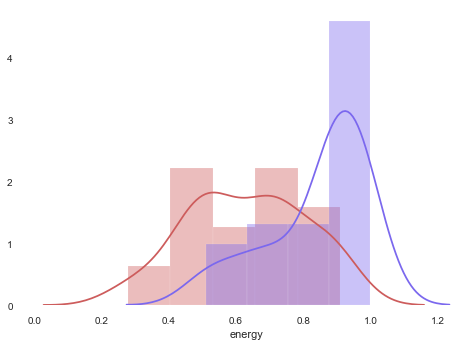

In [53]:
sns.distplot(test_df['energy'][test_df['target'] == 1], color='indianred', axlabel='Energy')
sns.distplot(test_df['energy'][test_df['target'] == 0], color='mediumslateblue')
plt.show()

##### Loudness

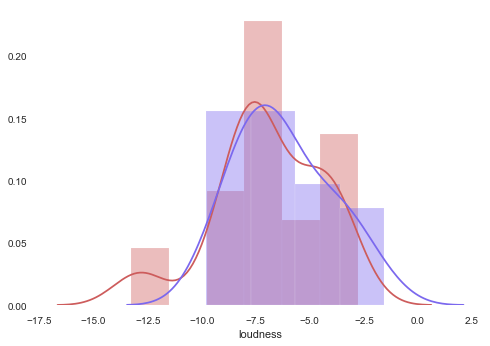

In [54]:
sns.distplot(test_df['loudness'][test_df['target'] == 1], color='indianred', axlabel='Loudness')
sns.distplot(test_df['loudness'][test_df['target'] == 0], color='mediumslateblue')
plt.show()

##### Speechiness

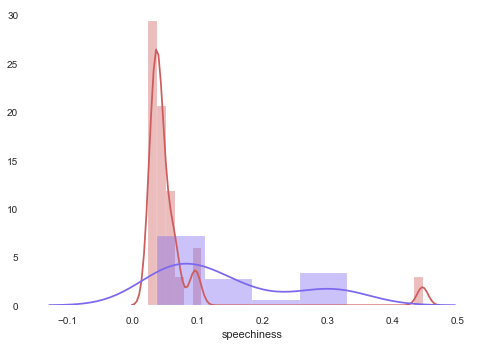

In [55]:
sns.distplot(test_df['speechiness'][test_df['target'] == 1], color='indianred', axlabel='Speechiness')
sns.distplot(test_df['speechiness'][test_df['target'] == 0], color='mediumslateblue')
plt.show()

##### Acousticness

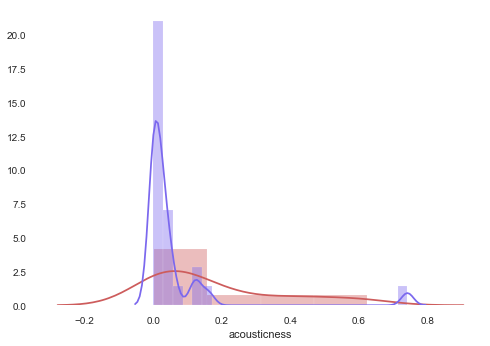

In [56]:
sns.distplot(test_df['acousticness'][test_df['target'] == 1], color='indianred', axlabel='Acousticness')
sns.distplot(test_df['acousticness'][test_df['target'] == 0], color='mediumslateblue')
plt.show()

##### Instrumentalness

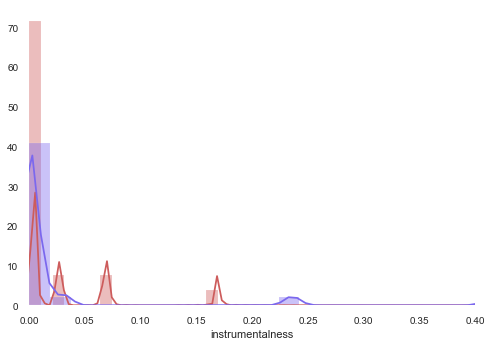

In [57]:
sns.distplot(test_df['instrumentalness'][test_df['target'] == 1], color='indianred', axlabel='Instrumentalness')
sns.distplot(test_df['instrumentalness'][test_df['target'] == 0], color='mediumslateblue')
plt.xlim(0.0,  0.4)
plt.show()


##### Liveness

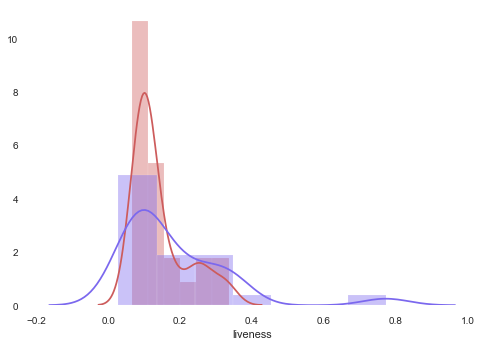

In [58]:
sns.distplot(test_df['liveness'][test_df['target'] == 1], color='indianred', axlabel='Liveness')
sns.distplot(test_df['liveness'][test_df['target'] == 0], color='mediumslateblue')
plt.show()


##### Valence

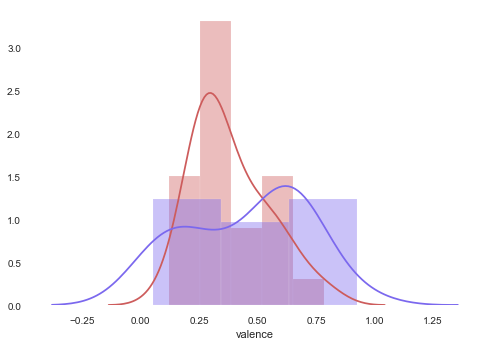

In [59]:
sns.distplot(test_df['valence'][test_df['target'] == 1], color='indianred', axlabel='Valence')
sns.distplot(test_df['valence'][test_df['target'] == 0], color='mediumslateblue')
plt.show()


##### Key

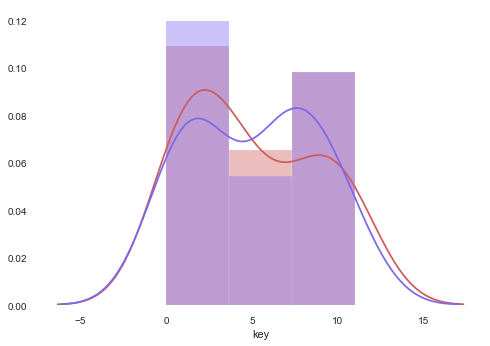

In [60]:
sns.distplot(test_df['key'][test_df['target'] == 1], color='indianred', axlabel='Key')
sns.distplot(test_df['key'][test_df['target'] == 0], color='mediumslateblue')
plt.show()


##### Time Signature & Mode

C:\Users\febel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


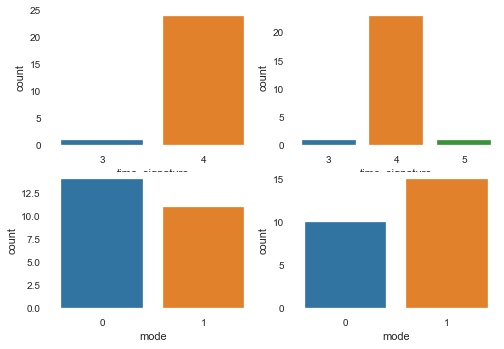

In [61]:
fig, ax = plt.subplots(2, 2)
sns.countplot(test_df['time_signature'][test_df['target'] == 1], ax=ax[0,0])
sns.countplot(test_df['time_signature'][test_df['target'] == 0], ax=ax[0,1])
sns.countplot(test_df['mode'][test_df['target'] == 1], ax=ax[1,0])
sns.countplot(test_df['mode'][test_df['target'] == 0], ax=ax[1,1])
fig.show()
# fig.savefig('like_freq_plots.png')

#### Testing/Evaluation

Accuracy using AdaBoost:  60.0 %
              precision    recall  f1-score   support

      Actual       0.65      0.44      0.52        25
   Predicted       0.58      0.76      0.66        25

    accuracy                           0.60        50
   macro avg       0.61      0.60      0.59        50
weighted avg       0.61      0.60      0.59        50



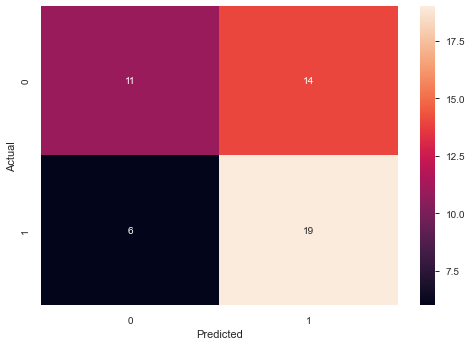

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

adab = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
adab.fit(x_train, y_train)
adab_pred = adab.predict(test_df[features])
score = accuracy_score(test_df['target'], adab_pred) * 100
print("Accuracy using AdaBoost: ", round(score, 1), "%")

# Add predictions to dataframe
test_df['pred'] = adab_pred

# Generate evaluation report
print(classification_report(test_df['target'], test_df['pred'], 
                            target_names=['Actual', 'Predicted']))

# Generate confusion matrix
confusion_matrix = pd.crosstab(test_df['target'], test_df['pred'], 
                               rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

## "Discover Weekly" Playlist Generator

In [63]:
scope = "user-top-read"
red_uri = 'http://localhost:8080/callback'

# Connect and create Spotify instance
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp2 = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=cid, client_secret=secret,
                                                scope=scope, redirect_uri=red_uri,
                                                username='francescab13'))

#### Get top 20 tracks from profile

In [64]:
# Create list of liked track IDs
liked_tracks = list(full_df['id'][full_df['target'] == 1])
top_tracks = sp2.current_user_top_tracks(limit=20, offset=0, time_range='medium_term')
top_20 = top_tracks['items']

# Get nested JSON
t20 = []
for i in top_20:
    t20.append(i['uri'])

#### Generate list of recommended songs
##### 2 recommended songs per input track

In [65]:
# Create list of recommended songs
# Note: Spotipy's 'recommendations' function can only take 5 track IDs at a time
# Five songs will be added to the playlist for every five track IDs analyzed
recs = []
i = 0
for i in range(0, len(t20)):
    if i == 0:
        recs.append(sp2.recommendations(seed_tracks=t20[0:5], limit=2))
        i += 5
    else:
        recs.append(sp2.recommendations(seed_tracks=t20[i:i+5], limit=2))
        i += 5

In [66]:
rec_tracks = []
for i in recs:
    rec_tracks.append(i['tracks'])

# Flatten list of lists of JSON
rec_flatten = []
for sublist in rec_tracks:
    for item in sublist:
        rec_flatten.append(item)
rec_flatten[0:3]

[{'album': {'album_type': 'ALBUM',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3o2dn2O0FCVsWDFSh8qxgG'},
     'href': 'https://api.spotify.com/v1/artists/3o2dn2O0FCVsWDFSh8qxgG',
     'id': '3o2dn2O0FCVsWDFSh8qxgG',
     'name': 'Sabaton',
     'type': 'artist',
     'uri': 'spotify:artist:3o2dn2O0FCVsWDFSh8qxgG'},
    {'external_urls': {'spotify': 'https://open.spotify.com/artist/4Lm0pUvmisUHMdoky5ch2I'},
     'href': 'https://api.spotify.com/v1/artists/4Lm0pUvmisUHMdoky5ch2I',
     'id': '4Lm0pUvmisUHMdoky5ch2I',
     'name': 'Apocalyptica',
     'type': 'artist',
     'uri': 'spotify:artist:4Lm0pUvmisUHMdoky5ch2I'}],
   'available_markets': ['AD',
    'AE',
    'AL',
    'AR',
    'AT',
    'AU',
    'BA',
    'BE',
    'BG',
    'BH',
    'BO',
    'BR',
    'BY',
    'CA',
    'CH',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DE',
    'DK',
    'DO',
    'DZ',
    'EC',
    'EE',
    'EG',
    'ES',
    'FI',
    'FR',
    'GB',
    'GR

In [67]:
rec_df = pd.DataFrame.from_records(rec_flatten)
rec_df.head()

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,353266,False,{'isrc': 'DED831901513'},{'spotify': 'https://open.spotify.com/track/6W...,https://api.spotify.com/v1/tracks/6W4pRJhZhyO3...,6W4pRJhZhyO3rz9vTITKRB,False,Angels Calling,58,https://p.scdn.co/mp3-preview/9f28e3b15476f724...,1,track,spotify:track:6W4pRJhZhyO3rz9vTITKRB
1,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,281853,False,{'isrc': 'USRE19900712'},{'spotify': 'https://open.spotify.com/track/4Y...,https://api.spotify.com/v1/tracks/4Y7fEQ4PAzhl...,4Y7fEQ4PAzhlLnLviRw2P4,False,Rockin' in the Free World,67,https://p.scdn.co/mp3-preview/5ad604341184d350...,12,track,spotify:track:4Y7fEQ4PAzhlLnLviRw2P4
2,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,233719,False,{'isrc': 'GBAAP0600166'},{'spotify': 'https://open.spotify.com/track/4Z...,https://api.spotify.com/v1/tracks/4ZuC5MfGjRQs...,4ZuC5MfGjRQs3pZtPxqMYP,False,Shadowplay - 2007 Remaster,57,https://p.scdn.co/mp3-preview/c906878737a9208f...,7,track,spotify:track:4ZuC5MfGjRQs3pZtPxqMYP
3,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,177261,True,{'isrc': 'ushm91897084'},{'spotify': 'https://open.spotify.com/track/32...,https://api.spotify.com/v1/tracks/32YH38VAxq1M...,32YH38VAxq1MpPw8jNGbJD,False,Welcome to the Mario Party,48,https://p.scdn.co/mp3-preview/ce2e27481beb7c88...,5,track,spotify:track:32YH38VAxq1MpPw8jNGbJD
4,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[CA, US]",1,295890,False,{'isrc': 'NLRD51831603'},{'spotify': 'https://open.spotify.com/track/1d...,https://api.spotify.com/v1/tracks/1dlJQt9NLH5i...,1dlJQt9NLH5iFCIeiVz5lX,False,Gold (Stupid Love),53,https://p.scdn.co/mp3-preview/499f1ca21fd7213c...,5,track,spotify:track:1dlJQt9NLH5iFCIeiVz5lX


#### Get features for recommended songs

In [68]:
# Compile list of test track IDs
rec_id_list = list(rec_df['uri'])

# Retrieve track characteristics
rec_features = []
for i in range(0, len(rec_id_list)):
    if not rec_id_list[i]:
        continue
    else:
        rec_features.append(sp.audio_features(rec_id_list[i]))

# Flatten JSON list
rec_features_flat = []
for sublist in rec_features:
    for item in sublist:
        rec_features_flat.append(item)

In [69]:
# Add features column to dataframe
rec_df['features'] = rec_features_flat

# Separate out features into columns
feature_df = pd.json_normalize(rec_df['features'])
# Drop duplicate columns from feature_df
feature_df.drop(['type', 'id', 'uri', 'track_href'], axis=1, inplace=True)

# Concatenate feature dataframe with rec dataframe
merged_df = pd.concat([rec_df, feature_df], axis=1, sort=False)

#### Filter recommended songs through AdaBoost model

In [70]:
adab = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
adab.fit(x_train, y_train)
adab_pred = adab.predict(merged_df[features])

# Add AdaBoost predictions to dataframe
merged_df['prediction'] = adab_pred

In [71]:
# Filter down dataframe to only positive predictions
final_df = merged_df[merged_df['prediction'] == 1]

#### Add filtered songs to playlist

In [72]:
scope = 'playlist-modify-public'
red_uri = 'http://localhost:8080/callback'

# Connect and create Spotify instance
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp3 = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=cid, client_secret=secret,
                                                scope=scope, redirect_uri=red_uri,
                                                username='francescab13'))

# Create Spotify playlist
sp3.user_playlist_add_tracks(user='francescab13',
                            playlist_id='3ltrx1uwJp4VciDPYBTG4r',
                            tracks=list(final_df['uri']))

{'snapshot_id': 'OSxhODNlMTI1MDE3NzcwOThjZmE4MDYyNGYzMTI0ZTA2NDYyODJmNjIw'}